In [1]:
import copy
import h5py
import itertools
import numpy as np
import os
import pandas as pd
import scipy
import scipy.interpolate
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import palettable

In [3]:
import yt
import trident
import unyt as u

In [4]:
import kalepy as kale
import verdict

# Parameters

In [5]:
# Analysis parameters
seed = 15482
rng = np.random.default_rng( seed )
verbose = False
Z_sun = 0.014

In [6]:
# Data management parameters
distribution_fp = './data/EAGLE/histogram_galaxies_logM200c-Msun-12.0-12.5_200_seed0_hneutralssh.hdf5'
data_dir = './data/synthetic_data/sample1'
observer_data_dir = './data/synthetic_data_samples/sample1'
figure_dir = '/Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample1'

In [7]:
os.makedirs( figure_dir, exist_ok=True )

In [8]:
# Ray parameters
redshift = 0.25
n_sightlines = 100
min_clouds_per_sightline = 1
max_clouds_per_sightline = 3
velocity_range = [ -150., 150. ] # In km/s
finite_cloud_max_logT = 5 # We'll only allow one cloud per line of sight with temperatures greater than this

In [9]:
# Spectra parameters
ions = [
    'H I',
    'O I',
    'C II',
    'C III',
    'N II',
    'N III',
    'Si II',
    'Si III',
    'Si IV',
#     'N V',
    'O VI',
    'Mg II'
]
fields = [
    'H_p0_number_density', 
    'O_p0_number_density',
    'C_p1_number_density',
    'C_p2_number_density',
    'N_p1_number_density',
    'N_p2_number_density',
    'Si_p1_number_density',
    'Si_p2_number_density',
    'Si_p3_number_density',
#     'N_p4_number_density',
    'O_p5_number_density',
    'Mg_p1_number_density'
]
snr = 30

In [26]:
# Plotting parameters
colors = palettable.cartocolors.qualitative.Safe_10.mpl_colors
modeled_color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[1]
revised_color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[0]

# Load Data

## Modeled Data

In [11]:
modeled_data_dir = './data/modeling_results/sameer_charlton/sample1/pdfs'

In [12]:
# Load into a dictionary
modeled = {}
for dirname in tqdm.tqdm( os.listdir( modeled_data_dir ) ):
        
    # Get dirs, skip others
    current_dir = os.path.join( modeled_data_dir, dirname )
    if not os.path.isdir( current_dir ):
        continue
        
    modeled_dir = {}
    for file in os.listdir( current_dir ):
        comp_key = file.split( '.' )[0]
        
        fp = os.path.join( current_dir, file )
        df = pd.read_csv( fp, sep=' ', header=None, )
        df.columns = [ 'Prob', 'Likelihood', 'logZ', 'logT', 'lognH' ]
        
        modeled_dir[comp_key] = df
        
    modeled[dirname[:3]] = modeled_dir

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 50.84it/s]


In [52]:
modeled[sl]['MgII_0']

,Prob,Likelihood,logZ,logT,lognH
0,1.140878e-99,642.812636,-1.351468,4.053001,-3.557152
1,1.140296e-99,642.811658,-0.802575,4.220191,-2.046568
2,1.717290e-99,641.990739,-1.914439,4.174905,-3.053498
3,1.885232e-99,641.802132,-1.819980,4.058357,-3.984752
4,2.322755e-99,641.382725,-0.375396,4.363904,-2.912960
...,...,...,...,...,...
14357,3.605227e-04,176.298295,-0.494723,4.335929,-3.267435
14358,1.929833e-04,177.548198,-0.493502,4.336554,-3.318197
14359,1.527949e-04,178.015212,-0.512035,4.341640,-3.266181
14360,1.420724e-04,178.160732,-0.467159,4.328407,-3.206684


In [40]:
# Generate histograms, and store in a format conducive to plotting
sl_keys = sorted( list( modeled.keys() ) )
params = [ 'logZ', 'logT', 'lognH' ]
dx = 0.0
dists = {}
for param in params:
    
    param_dists = {
        'xs': [],
        'values': [],
    }
    for i, sl in enumerate( sl_keys ):
        
        for j, ( comp_key, df ) in enumerate( modeled[sl].items() ):
            
            values = df[param].values
            
            x = i + j*dx
            
            param_dists['xs'].append( x )
            param_dists['values'].append( values )
            
    dists[param] = param_dists

In [14]:
# Count the number of components
n_comp_modeled = [ len( modeled[sl].keys() ) for sl in sl_keys ]

## Generated Data

In [15]:
sls = verdict.Dict.from_hdf5( './data/synthetic_data/sample1/sightlines.h5', jagged_flag='sl')

/Users/zhafen/repos/verdict/verdict.py:1410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [16]:
clouds = {}
for key, item in sls.items():
    clouds[key] = np.concatenate( item )

In [17]:
# Used sightlines
indices = np.array( sl_keys ).astype( int )

In [18]:
# Particular sightlines chosen
combined = {
    'logZ': [],
    'logT': [],
    'lognH': [],
}
for i in indices:
    
    print( 'Sightline {:03d}'.format( i ) )

    density = 10.**sls['Density'][i] * u.g * u.cm**-3 / u.mp * 0.75
    temperature = 10.**sls['Temperature'][i] * u.K
    metallicity = 10.**sls['Metallicity'][i] / Z_sun
    HI_column = 10.**sls['HI Column'][i] * u.cm**-2
    velocity = sls['LOS Velocity'][i] * u.km / u.s
    lengths = sls['Lengths'][i] * u.cm
    
    for j, den in enumerate( density ):
        
        print( '    logZ = {:.3g}, logT = {:.3g}, logn = {:.3g}'.format( 
                np.log10( metallicity[j] ),
                np.log10( temperature[j] ),
                np.log10( den ),
            )
        )

    if len( velocity ) == 2:
        print( '    delta_v = {:.3g}'.format( np.abs( velocity[1] - velocity[0] ) ) )
    
    den = ( density * lengths ).sum() / lengths.sum()
    temp = ( temperature * density * lengths ).sum() / ( density * lengths ).sum()
    met = ( metallicity * Z_sun * density * lengths ).sum() / ( Z_sun * density * lengths ).sum()
    print( '    Combined, logZ = {:.3g}, logT = {:.3g}, logn = {:.3g}'.format( 
            np.log10( met ),
            np.log10( temp ),
            np.log10( den ),
        )
    )
    
    combined['lognH'].append( den )
    combined['logZ'].append( met )
    combined['logT'].append( temp )

Sightline 005
    logZ = -1.2, logT = 5.45, logn = -4.36
    logZ = 1.53, logT = 4.69, logn = -2.83
    delta_v = 11 km/s
    Combined, logZ = 1.19, logT = 5.25, logn = -4.11
Sightline 010
    logZ = -1.03, logT = 4.13, logn = -2.69
    Combined, logZ = -1.03, logT = 4.13, logn = -2.69
Sightline 022
    logZ = -1.68, logT = 5.11, logn = -3.95
    logZ = -2.16, logT = 4.42, logn = -3.37
    delta_v = 116 km/s
    Combined, logZ = -1.71, logT = 5.07, logn = -3.92
Sightline 028
    logZ = 0.161, logT = 5.36, logn = -4.05
    Combined, logZ = 0.161, logT = 5.36, logn = -4.05
Sightline 034
    logZ = 1.79, logT = 4.23, logn = -3.42
    Combined, logZ = 1.79, logT = 4.23, logn = -3.42
Sightline 046
    logZ = 1.39, logT = 5.61, logn = -3.91
    Combined, logZ = 1.39, logT = 5.61, logn = -3.91
Sightline 050
    logZ = 0.0205, logT = 4.7, logn = -3.41
    logZ = -2.26, logT = 5.71, logn = -4.35
    logZ = 0.625, logT = 4.48, logn = -2.66
    Combined, logZ = -0.0925, logT = 5.6, logn = -4.24
S

# Plot

In [19]:
x_labels = {
    'logZ': r'$\log_{10} Z / Z_\odot$',
    'logT': r'$\log_{10} T / K$',
    'lognH': r'$\log_{10} n_{\rm H} / {\rm cm}^{-3}$',
}
param_mapping = {
    'logZ': 'Metallicity',
    'logT': 'Temperature',
    'lognH': 'Density',
}

In [20]:
indices

array([ 5, 10, 22, 28, 34, 46, 50, 71, 76, 97])

Saving at /Users/zhafen/paper_repos/cgm_modeling_challenge_paper/figures/sample1/comparison.pdf


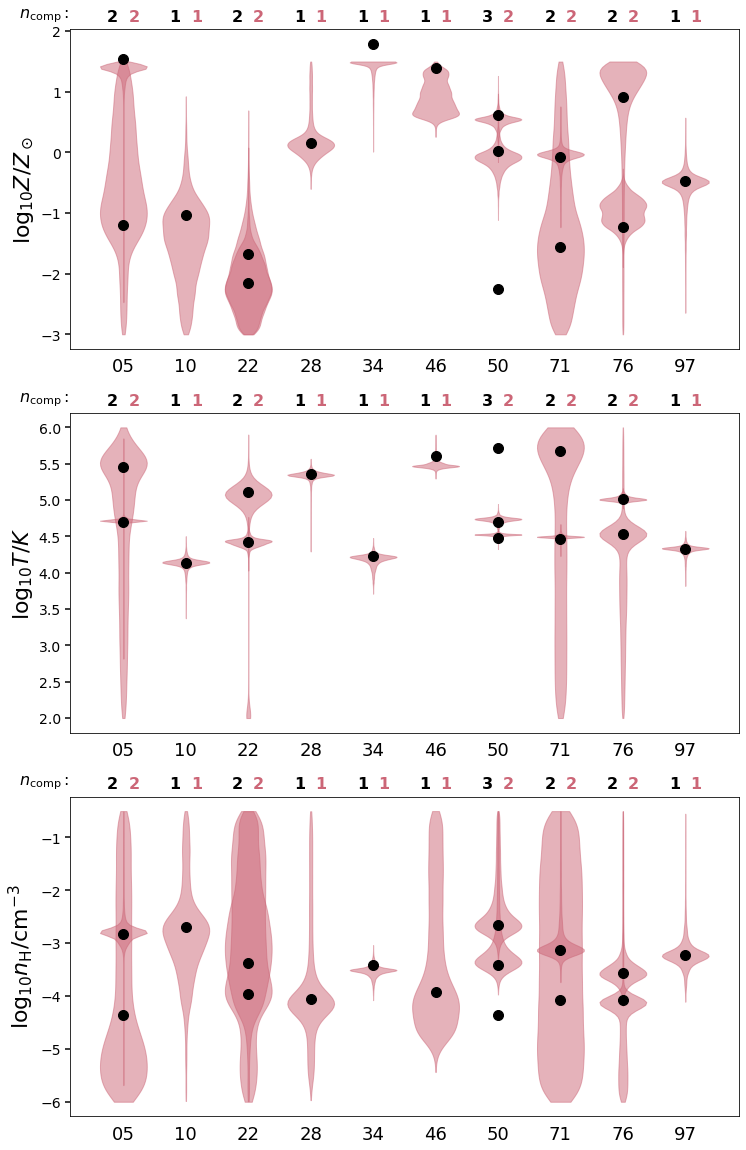

In [33]:
fig = plt.figure( figsize=(12,20), facecolor='w' )
# ax_main = plt.gca()

gs = matplotlib.gridspec.GridSpec( 3, 1 )
# gs.update( hspace=0.1)

main_xs = np.arange( len( indices ) )

for i, param in enumerate( params ):
    ax = fig.add_subplot( gs[i,0] )
    
#     # Combined
#     ax.scatter(
#         main_xs,
#         np.log10( combined[param] ),
#         color = 'none',
#         edgecolor = 'k',
#         s = 200,
#         zorder = 100,
#     )

    # Individual clouds
    for i, ind in enumerate( indices ):

        if param == 'logZ':
            ys = np.log10( 10.**sls[param_mapping[param]][ind] / Z_sun )
        elif param == 'lognH':
            ys = np.log10( 10.**sls[param_mapping[param]][ind] * u.g * u.cm**-3 / u.mp * 0.75 )
        else:
            ys = sls[param_mapping[param]][ind]

        xs = np.full( ys.size, i )
        ax.scatter(
            xs,
            ys,
            color = 'k',
            s = 100,
            zorder = 90,
        )
        
        ax.annotate(
            text = '{}'.format( ys.size ),
            xy = (i, 1),
            xycoords = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
            xytext = ( -5, 5 ),
            textcoords = 'offset points',
            va = 'bottom',
            ha = 'right',
            fontsize = 16,
            fontweight = 'bold',
        )
    
    # Annotate number of modeled components
    ax.annotate(
        text = r'$n_{\rm comp}:$',
        xy = ( 0, 1 ),
        xycoords = 'axes fraction',
        xytext = ( 0, 5 ),
        textcoords = 'offset points',
        fontsize = 16,
        va = 'bottom',
        ha = 'right',
        fontweight = 'bold',
    )
    for i, n_comp in enumerate( n_comp_modeled ): 
        ax.annotate(
            text = '{}'.format( n_comp ),
            xy = (i, 1),
            xycoords = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            va = 'bottom',
            ha = 'left',
            fontsize = 16,
            color = modeled_color,
            fontweight = 'bold',
        )
        
    # Violin plot
    v = ax.violinplot(
        dists[param]['values'],
        dists[param]['xs'],
        showextrema = False,
        widths = 0.75,
#         showmeans = True,
#         showmedians = True,
#         quantiles = [ [ 0.01135, 0.5, 1. - 0.01135 ], ] * len( dists[param]['xs'] )
    )
    for i, poly in enumerate( v['bodies'] ):
        poly.set_alpha( 0.5 )
        poly.set_color( modeled_color, )
    
    ax.set_ylabel( x_labels[param], fontsize=22 )

    ax.tick_params( bottom=False, length=5, width=1.5, labelsize=14 )

    tick_labels = [ _[1:] for _ in sl_keys ]
    plt.xticks( ticks=main_xs, labels=tick_labels, fontsize=18 )
    
savefile = os.path.join( figure_dir, 'comparison.pdf' )
print( 'Saving at {}'.format( savefile ) )
plt.savefig( savefile, bbox_inches='tight' )

In [42]:
dists[param]['xs']

[0.0, 0.0, 1.0, 2.0, 2.0, 3.0, 4.0, 5.0, 6.0, 6.0, 7.0, 7.0, 8.0, 8.0, 9.0]

In [41]:
dists[param]['kdes']